# Hierarchical Clustering Testing
- Normal hierarchical clustering methods
    - Test: single linkage, complete linkage, average linkage
- Graph Attention Networks to "enhance" embeddings


### Embedding Code

In [22]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

MODEL_ID = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = None
model = None

def mean_pooling(model_output, attention_mask):
    """
    This function takes the model output and attention mask as input and performs mean pooling on the token embeddings.
    Args:
        model_output (tuple): The output of the model, which includes the token embeddings.
        attention_mask (torch.Tensor): The attention mask indicating which tokens are valid.
    Returns:
        torch.Tensor: The mean-pooled token embeddings.
    """
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


def get_embeddings(input: list[str]):
    """
    This function takes an input string and returns the embedding of the input using the initialized model.
    If the model is not initialized, it will be initialized before generating the embedding.
    Args:
        input List[str]: Input strings to be embedded.
    Returns:
        torch.Tensor: The embedding of the input string.
    """
    global tokenizer, model

    if tokenizer is None or model is None:
        print("Initalizing Tokenizer and Model")
        tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
        model = AutoModel.from_pretrained(MODEL_ID)

    encoded_input = tokenizer(input, padding=True, truncation=True, return_tensors='pt')

    with torch.no_grad():
        model_output = model(**encoded_input)

    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    return sentence_embeddings

## Dendrogram

### Load data and get embeddings

In [65]:
import numpy as np
import pandas as pd
import uuid
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA

In [17]:
with open("../data/ismir2021.json", "r") as f:
    ismir_df = pd.read_json(f)

ismir_df['combined'] = ismir_df.apply(lambda x: f'title: {x["title"]}, abstract: {x["abstract"]}', axis=1)
ismir_df['uuid'] = ismir_df.apply(lambda x: uuid.uuid5(uuid.NAMESPACE_DNS, x['combined']), axis=1)

In [25]:
embeddings = get_embeddings(list(ismir_df['combined']))
embeddings

tensor([[ 0.0042, -0.1331,  0.0523,  ...,  0.0146,  0.0005, -0.0458],
        [-0.0643, -0.1229,  0.0612,  ...,  0.0499,  0.0103, -0.0420],
        [-0.0461,  0.0585, -0.0038,  ..., -0.0704,  0.0204, -0.0278],
        ...,
        [-0.0577, -0.0708,  0.0167,  ...,  0.0079,  0.0004, -0.0312],
        [-0.0699, -0.1192,  0.0086,  ..., -0.0170, -0.0171, -0.0024],
        [-0.0603, -0.0372,  0.0648,  ...,  0.0165,  0.0438, -0.0712]])

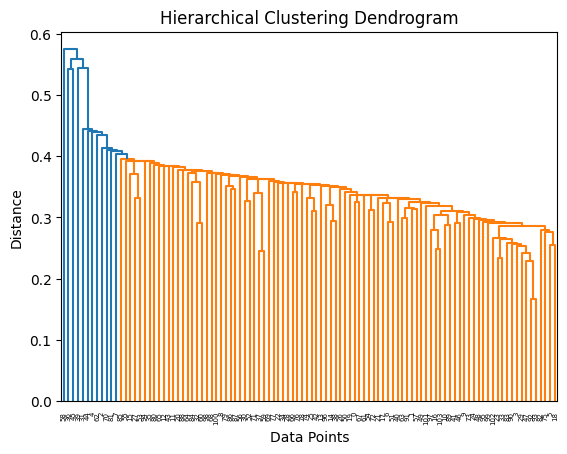

In [31]:
linkage_matrix = linkage(embeddings, method='single', metric='cosine')

dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

In [63]:
# Cluster assignments

threshold = 1

clusters = fcluster(linkage_matrix, threshold, criterion='distance')
print("Cluster assignments:", clusters)

Cluster assignments: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


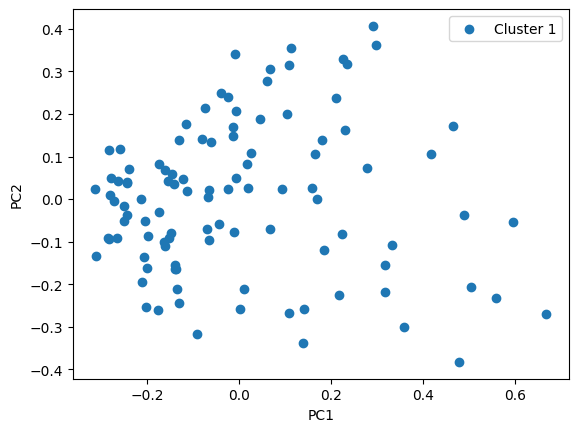

In [64]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

fig = plt.figure()
ax = fig.add_subplot(111)

for cluster in np.unique(clusters):
    cluster_indices = np.where(clusters == cluster)
    ax.scatter(reduced_embeddings[cluster_indices, 0], reduced_embeddings[cluster_indices, 1], label=f'Cluster {cluster}')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

plt.show()